In [1]:
__author__ = "Francesca Vera and Robert Fernandez"
__version__ = "CS224u, Stanford, Spring 2019"

In [83]:
#Data reader:
from __future__ import unicode_literals, print_function, division
import csv
import unicodedata
import string
import numpy as np
from sklearn.model_selection import train_test_split

Twitter_Ids = []
Labels = [] #range is sexism, racism, neither, and both
Hashtags = []
Text = []

LabelTags = ["sexism", "racism", "neither", "both"]

LTest =["sexism", "neither"]

#n_labels = len(LabelTags)
n_labels = len(LTest)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Extraction

#extracts only sexism or neither types
def extract2(s):
    with open(s, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if row['Label'] != 'racism' and row['Label'] != 'both':
                #data retained is something called an ordered dict
                Twitter_Ids.append(row['Twitter_Id'])
                Labels.append(row['Label'])
                Hashtags.append(row['Hashtags'])
                #convert unicode text into ascii:

                Text.append(unicodeToAscii(row['Text'])) #keeps the hyperlinks in an odd form, removes '#'.
                #can mod unicode to remove http- words

extract2('data/ternary_labels_second.csv')
extract2('data/saved_data_benevolent_sexist.csv')
extract2('data/saved_data_hostile.csv')

#split data into train/test
#sklearn func splits it for us. This operation should be done after preprocessing of text data and applying for features
X_train, X_test, y_train, y_test = train_test_split(Text, Labels, test_size=0.1, random_state=42)
        

In [67]:
#Data evaluation. I think we need more of an even labeling spread. We need to eval on an equal number of sexism,
#racism, neither, or both

s = 0
r = 0
n = 0
b = 0

typeLines = [[],[]]

for i in range(len(Labels)):
    if Labels[i] == 'sexism':
        s +=1
        typeLines[0].append(i)
    if Labels[i] == 'neither':
        n +=1
        typeLines[1].append(i)
    if Labels[i] == 'both':
        b +=1
    if Labels[i] == 'racism':
        r +=1
        
print(s, r, n, b)

4610 0 5557 0


In [ ]:
#separate data into train, validation, and test

In [8]:
print(X_train[:5])

["amaninblack I'm not mentioning names for a few different reasons.", 'ChrisWarcraft srhbutts what did he do this time I am still waiting for him to sue me.', 'tjathurman sarahlicity Women must be addressed as milady until they turn you down at which point the correct form of address is feminazi', 'Dealing with journalists  Interviews are back and forth, not a monologue. Even if the interviewer is a woman.  wadhwa', "Are you upset about tonight's elimination result MKR"]


In [68]:
#RNN:
#just pulled from a tutorial. PyTorch has built in rnn modules, but specifying may give us more control.
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [69]:
#training example fetcher if we want to use it

import random
import torch

def randomChoice(l):
    i = random.randint(0, len(l) - 1)
    return l[i], i

def TrainingExample(i):
    line = Text[i]
    category = Labels[i]
    category_tensor = torch.tensor([LTest.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTrainingExample():
    #print(category)
    line, i = randomChoice(X_train)
    category = y_train[i]
    category_tensor = torch.tensor([LTest.index(y_train[i])], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

#---String to Tensor Converters---

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LTest[category_i], category_i


In [70]:
#loss function setup

criterion = nn.NLLLoss()
#criterion = nn.CosineEmbeddingLoss()


In [71]:
#training function

def train(category_tensor, line_tensor, learning_rate):
    hidden = rnn.initHidden() #passovers, rnn was established beforehand

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


In [84]:
#training harness
import time
import math

n_iters = 5000
print_every = 2
plot_every = 2

#Hyperparameters
learning_rate = 0.01 
n_hidden = 128 #Hyperparameter



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#instantiate our model:
rnn = RNN(n_letters, n_hidden, n_labels)

start = time.time()

for i in range(n_iters):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, learning_rate)
    current_loss += loss

    # Print iter number, loss, name and guess on print call
    if i % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s' % (i, i / n_iters * 100, timeSince(start), loss, guess, correct))

    # Add current loss avg to list of losses on plot request
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


0 0% (0m 0s) 0.6904 sexism / ✓
2 0% (0m 0s) 0.6822 sexism / ✓
4 0% (0m 0s) 0.7357 neither / ✗ (sexism)
6 0% (0m 0s) 0.7177 neither / ✗ (sexism)
8 0% (0m 0s) 0.7421 neither / ✗ (sexism)
10 0% (0m 0s) 0.6543 sexism / ✓
12 0% (0m 0s) 0.6963 neither / ✗ (sexism)
14 0% (0m 0s) 0.6994 sexism / ✗ (neither)
16 0% (0m 0s) 0.6401 sexism / ✓
18 0% (0m 0s) 0.7163 sexism / ✗ (neither)
20 0% (0m 0s) 0.6951 sexism / ✗ (neither)
22 0% (0m 0s) 0.6928 sexism / ✓
24 0% (0m 0s) 0.6307 sexism / ✓
26 0% (0m 0s) 0.7364 sexism / ✗ (neither)
28 0% (0m 0s) 0.6081 sexism / ✓
30 0% (0m 0s) 0.6061 sexism / ✓
32 0% (0m 0s) 0.6164 sexism / ✓
34 0% (0m 1s) 0.6924 neither / ✓
36 0% (0m 1s) 0.5965 sexism / ✓
38 0% (0m 1s) 0.6619 sexism / ✓
40 0% (0m 1s) 0.6979 sexism / ✗ (neither)
42 0% (0m 1s) 0.6488 sexism / ✓
44 0% (0m 1s) 0.6529 sexism / ✓
46 0% (0m 1s) 0.5305 sexism / ✓
48 0% (0m 1s) 0.5189 sexism / ✓
50 1% (0m 1s) 0.7583 sexism / ✗ (neither)
52 1% (0m 1s) 0.4960 sexism / ✓
54 1% (0m 1s) 0.5488 sexism / ✓
56 1% (0

448 8% (0m 14s) 0.6344 neither / ✓
450 9% (0m 14s) 0.5469 sexism / ✓
452 9% (0m 14s) 0.2740 sexism / ✓
454 9% (0m 14s) 0.7464 neither / ✗ (sexism)
456 9% (0m 14s) 0.5241 sexism / ✓
458 9% (0m 14s) 0.8614 sexism / ✗ (neither)
460 9% (0m 14s) 0.7630 sexism / ✗ (neither)
462 9% (0m 15s) 0.2908 sexism / ✓
464 9% (0m 15s) 0.5972 neither / ✓
466 9% (0m 15s) 0.6000 sexism / ✓
468 9% (0m 15s) 0.2759 sexism / ✓
470 9% (0m 15s) 0.6160 neither / ✓
472 9% (0m 15s) 0.6040 neither / ✓
474 9% (0m 15s) 0.6251 neither / ✓
476 9% (0m 15s) 0.5280 sexism / ✓
478 9% (0m 15s) 0.5762 neither / ✓
480 9% (0m 15s) 0.5918 neither / ✓
482 9% (0m 15s) 0.5234 sexism / ✓
484 9% (0m 15s) 0.5763 sexism / ✓
486 9% (0m 15s) 0.7595 sexism / ✗ (neither)
488 9% (0m 15s) 0.5649 sexism / ✓
490 9% (0m 15s) 0.5336 neither / ✓
492 9% (0m 15s) 0.8606 neither / ✗ (sexism)
494 9% (0m 15s) 0.5305 sexism / ✓
496 9% (0m 15s) 0.6087 sexism / ✓
498 9% (0m 16s) 0.5761 sexism / ✓
500 10% (0m 16s) 0.7660 sexism / ✗ (neither)
502 10% (0m 1

884 17% (0m 28s) 0.7543 sexism / ✗ (neither)
886 17% (0m 28s) 0.9986 neither / ✗ (sexism)
888 17% (0m 28s) 0.5192 neither / ✓
890 17% (0m 28s) 0.7628 sexism / ✗ (neither)
892 17% (0m 28s) 0.5791 sexism / ✓
894 17% (0m 28s) 0.2417 sexism / ✓
896 17% (0m 28s) 0.5364 sexism / ✓
898 17% (0m 28s) 0.7615 sexism / ✗ (neither)
900 18% (0m 29s) 0.4365 neither / ✓
902 18% (0m 29s) 0.4787 neither / ✓
904 18% (0m 29s) 0.4826 sexism / ✓
906 18% (0m 29s) 0.4759 neither / ✓
908 18% (0m 29s) 0.2487 sexism / ✓
910 18% (0m 29s) 0.2302 sexism / ✓
912 18% (0m 29s) 0.8540 sexism / ✗ (neither)
914 18% (0m 29s) 0.9440 neither / ✗ (sexism)
916 18% (0m 29s) 0.4950 neither / ✓
918 18% (0m 29s) 0.7263 sexism / ✗ (neither)
920 18% (0m 29s) 0.7554 sexism / ✗ (neither)
922 18% (0m 29s) 0.2054 sexism / ✓
924 18% (0m 29s) 0.6051 sexism / ✓
926 18% (0m 29s) 0.2511 sexism / ✓
928 18% (0m 29s) 0.5953 sexism / ✓
930 18% (0m 29s) 0.6395 sexism / ✓
932 18% (0m 29s) 0.4593 neither / ✓
934 18% (0m 30s) 1.0198 neither / ✗ (se

1306 26% (0m 41s) 0.1611 sexism / ✓
1308 26% (0m 41s) 0.6014 sexism / ✓
1310 26% (0m 41s) 0.2097 sexism / ✓
1312 26% (0m 41s) 0.1857 sexism / ✓
1314 26% (0m 41s) 0.4855 sexism / ✓
1316 26% (0m 41s) 1.1572 neither / ✗ (sexism)
1318 26% (0m 41s) 1.0451 neither / ✗ (sexism)
1320 26% (0m 42s) 0.8370 sexism / ✗ (neither)
1322 26% (0m 42s) 0.3676 neither / ✓
1324 26% (0m 42s) 0.4533 neither / ✓
1326 26% (0m 42s) 1.1086 neither / ✗ (sexism)
1328 26% (0m 42s) 0.9818 sexism / ✗ (neither)
1330 26% (0m 42s) 0.1985 sexism / ✓
1332 26% (0m 42s) 0.1717 sexism / ✓
1334 26% (0m 42s) 0.9720 neither / ✗ (sexism)
1336 26% (0m 42s) 0.4410 neither / ✓
1338 26% (0m 42s) 0.7346 sexism / ✗ (neither)
1340 26% (0m 42s) 0.1416 sexism / ✓
1342 26% (0m 42s) 0.9976 neither / ✗ (sexism)
1344 26% (0m 42s) 0.1832 sexism / ✓
1346 26% (0m 42s) 0.9066 sexism / ✗ (neither)
1348 26% (0m 42s) 0.4343 neither / ✓
1350 27% (0m 42s) 0.4175 sexism / ✓
1352 27% (0m 43s) 0.8498 sexism / ✗ (neither)
1354 27% (0m 43s) 0.9361 sexism 

1728 34% (0m 54s) 0.3636 neither / ✓
1730 34% (0m 55s) 0.8154 sexism / ✗ (neither)
1732 34% (0m 55s) 0.3563 neither / ✓
1734 34% (0m 55s) 0.1672 sexism / ✓
1736 34% (0m 55s) 0.1289 sexism / ✓
1738 34% (0m 55s) 0.5549 sexism / ✓
1740 34% (0m 55s) 0.5203 sexism / ✓
1742 34% (0m 55s) 0.7701 sexism / ✗ (neither)
1744 34% (0m 55s) 0.1591 sexism / ✓
1746 34% (0m 55s) 0.3265 neither / ✓
1748 34% (0m 55s) 0.4050 neither / ✓
1750 35% (0m 55s) 0.8549 sexism / ✗ (neither)
1752 35% (0m 55s) 0.3516 neither / ✓
1754 35% (0m 55s) 0.1465 sexism / ✓
1756 35% (0m 55s) 0.7227 neither / ✗ (sexism)
1758 35% (0m 55s) 0.3422 neither / ✓
1760 35% (0m 55s) 0.3105 neither / ✓
1762 35% (0m 55s) 1.2591 neither / ✗ (sexism)
1764 35% (0m 55s) 0.4674 neither / ✓
1766 35% (0m 56s) 1.2794 neither / ✗ (sexism)
1768 35% (0m 56s) 0.4341 neither / ✓
1770 35% (0m 56s) 0.1171 sexism / ✓
1772 35% (0m 56s) 0.3788 neither / ✓
1774 35% (0m 56s) 0.3062 neither / ✓
1776 35% (0m 56s) 0.3035 neither / ✓
1778 35% (0m 56s) 0.1268 sex

2156 43% (1m 8s) 0.9198 sexism / ✗ (neither)
2158 43% (1m 8s) 0.8288 sexism / ✗ (neither)
2160 43% (1m 8s) 0.4865 neither / ✓
2162 43% (1m 8s) 0.5851 sexism / ✓
2164 43% (1m 8s) 0.3155 neither / ✓
2166 43% (1m 8s) 0.1565 sexism / ✓
2168 43% (1m 8s) 0.4447 neither / ✓
2170 43% (1m 8s) 0.3653 neither / ✓
2172 43% (1m 8s) 0.3243 sexism / ✓
2174 43% (1m 8s) 0.3180 neither / ✓
2176 43% (1m 8s) 0.5350 sexism / ✓
2178 43% (1m 9s) 0.4946 sexism / ✓
2180 43% (1m 9s) 0.3665 neither / ✓
2182 43% (1m 9s) 0.6056 sexism / ✓
2184 43% (1m 9s) 1.2096 neither / ✗ (sexism)
2186 43% (1m 9s) 0.5869 sexism / ✓
2188 43% (1m 9s) 0.3680 sexism / ✓
2190 43% (1m 9s) 1.0057 neither / ✗ (sexism)
2192 43% (1m 9s) 0.4799 sexism / ✓
2194 43% (1m 9s) 1.0466 neither / ✗ (sexism)
2196 43% (1m 9s) 0.4600 sexism / ✓
2198 43% (1m 9s) 0.1187 sexism / ✓
2200 44% (1m 9s) 0.5922 neither / ✓
2202 44% (1m 9s) 0.4676 sexism / ✓
2204 44% (1m 9s) 0.5483 neither / ✓
2206 44% (1m 10s) 0.9500 sexism / ✗ (neither)
2208 44% (1m 10s) 0.3

2576 51% (1m 21s) 0.1557 sexism / ✓
2578 51% (1m 21s) 0.1706 sexism / ✓
2580 51% (1m 21s) 0.4717 sexism / ✓
2582 51% (1m 21s) 0.4815 sexism / ✓
2584 51% (1m 21s) 0.4367 sexism / ✓
2586 51% (1m 21s) 0.4955 neither / ✓
2588 51% (1m 21s) 0.1386 sexism / ✓
2590 51% (1m 21s) 0.3444 sexism / ✓
2592 51% (1m 21s) 0.4652 neither / ✓
2594 51% (1m 21s) 0.4483 sexism / ✓
2596 51% (1m 21s) 0.1013 sexism / ✓
2598 51% (1m 21s) 0.1503 sexism / ✓
2600 52% (1m 21s) 0.0995 sexism / ✓
2602 52% (1m 21s) 0.1005 sexism / ✓
2604 52% (1m 21s) 0.4635 neither / ✓
2606 52% (1m 22s) 0.5130 sexism / ✓
2608 52% (1m 22s) 0.9634 sexism / ✗ (neither)
2610 52% (1m 22s) 0.4292 sexism / ✓
2612 52% (1m 22s) 0.0929 sexism / ✓
2614 52% (1m 22s) 2.3585 sexism / ✗ (neither)
2616 52% (1m 22s) 0.4123 sexism / ✓
2618 52% (1m 22s) 0.1246 sexism / ✓
2620 52% (1m 22s) 0.4722 sexism / ✓
2622 52% (1m 22s) 0.4530 sexism / ✓
2624 52% (1m 22s) 0.5505 sexism / ✓
2626 52% (1m 22s) 0.3558 neither / ✓
2628 52% (1m 22s) 0.1227 sexism / ✓
2630

3010 60% (1m 34s) 0.6213 sexism / ✓
3012 60% (1m 34s) 0.6705 sexism / ✓
3014 60% (1m 34s) 0.5446 sexism / ✓
3016 60% (1m 34s) 0.5479 sexism / ✓
3018 60% (1m 34s) 0.2482 neither / ✓
3020 60% (1m 34s) 1.2286 neither / ✗ (sexism)
3022 60% (1m 34s) 0.1346 sexism / ✓
3024 60% (1m 34s) 0.1356 sexism / ✓
3026 60% (1m 34s) 1.2340 neither / ✗ (sexism)
3028 60% (1m 35s) 0.1205 sexism / ✓
3030 60% (1m 35s) 0.6615 sexism / ✓
3032 60% (1m 35s) 0.2768 sexism / ✓
3034 60% (1m 35s) 0.2762 sexism / ✓
3036 60% (1m 35s) 0.4906 sexism / ✓
3038 60% (1m 35s) 0.4882 neither / ✓
3040 60% (1m 35s) 0.4502 sexism / ✓
3042 60% (1m 35s) 0.3520 neither / ✓
3044 60% (1m 35s) 1.2896 neither / ✗ (sexism)
3046 60% (1m 35s) 0.0941 sexism / ✓
3048 60% (1m 35s) 0.4459 sexism / ✓
3050 61% (1m 35s) 1.0258 neither / ✗ (sexism)
3052 61% (1m 35s) 0.8831 sexism / ✗ (neither)
3054 61% (1m 35s) 1.1657 sexism / ✗ (neither)
3056 61% (1m 35s) 1.0125 sexism / ✗ (neither)
3058 61% (1m 36s) 0.1446 sexism / ✓
3060 61% (1m 36s) 0.5819 ne

3434 68% (1m 48s) 0.7272 sexism / ✗ (neither)
3436 68% (1m 48s) 0.4532 sexism / ✓
3438 68% (1m 48s) 0.1854 sexism / ✓
3440 68% (1m 48s) 0.4275 sexism / ✓
3442 68% (1m 48s) 0.6771 neither / ✓
3444 68% (1m 48s) 0.1183 sexism / ✓
3446 68% (1m 48s) 0.8176 sexism / ✗ (neither)
3448 68% (1m 48s) 0.2790 neither / ✓
3450 69% (1m 48s) 0.1841 sexism / ✓
3452 69% (1m 48s) 0.1144 sexism / ✓
3454 69% (1m 48s) 1.4387 neither / ✗ (sexism)
3456 69% (1m 48s) 0.1367 sexism / ✓
3458 69% (1m 48s) 0.9774 sexism / ✗ (neither)
3460 69% (1m 48s) 1.1017 neither / ✗ (sexism)
3462 69% (1m 48s) 0.1579 sexism / ✓
3464 69% (1m 48s) 0.1537 sexism / ✓
3466 69% (1m 48s) 0.3709 sexism / ✓
3468 69% (1m 49s) 0.1041 sexism / ✓
3470 69% (1m 49s) 0.7887 sexism / ✗ (neither)
3472 69% (1m 49s) 0.4329 neither / ✓
3474 69% (1m 49s) 0.3589 sexism / ✓
3476 69% (1m 49s) 0.7689 sexism / ✗ (neither)
3478 69% (1m 49s) 0.4389 neither / ✓
3480 69% (1m 49s) 0.4022 sexism / ✓
3482 69% (1m 49s) 0.4268 sexism / ✓
3484 69% (1m 49s) 0.4125 n

3860 77% (2m 1s) 0.3212 neither / ✓
3862 77% (2m 1s) 0.3291 neither / ✓
3864 77% (2m 1s) 0.1112 sexism / ✓
3866 77% (2m 1s) 0.1401 sexism / ✓
3868 77% (2m 1s) 1.9650 sexism / ✗ (neither)
3870 77% (2m 1s) 0.4238 neither / ✓
3872 77% (2m 1s) 0.4189 neither / ✓
3874 77% (2m 1s) 0.1033 sexism / ✓
3876 77% (2m 1s) 0.2977 sexism / ✓
3878 77% (2m 1s) 0.7052 neither / ✗ (sexism)
3880 77% (2m 1s) 0.6570 neither / ✓
3882 77% (2m 1s) 0.2380 neither / ✓
3884 77% (2m 1s) 0.1794 sexism / ✓
3886 77% (2m 1s) 0.1518 sexism / ✓
3888 77% (2m 2s) 0.5887 neither / ✓
3890 77% (2m 2s) 0.7355 neither / ✗ (sexism)
3892 77% (2m 2s) 0.6276 neither / ✓
3894 77% (2m 2s) 0.1819 sexism / ✓
3896 77% (2m 2s) 0.1804 sexism / ✓
3898 77% (2m 2s) 0.5959 sexism / ✓
3900 78% (2m 2s) 0.2632 neither / ✓
3902 78% (2m 2s) 0.1912 neither / ✓
3904 78% (2m 2s) 0.6633 sexism / ✓
3906 78% (2m 2s) 0.2282 neither / ✓
3908 78% (2m 2s) 0.7926 neither / ✗ (sexism)
3910 78% (2m 2s) 1.4673 neither / ✗ (sexism)
3912 78% (2m 2s) 0.6872 neith

4290 85% (2m 14s) 0.2107 neither / ✓
4292 85% (2m 14s) 0.4667 neither / ✓
4294 85% (2m 14s) 0.5417 neither / ✓
4296 85% (2m 14s) 0.0853 sexism / ✓
4298 85% (2m 14s) 0.3832 sexism / ✓
4300 86% (2m 14s) 0.1897 sexism / ✓
4302 86% (2m 14s) 0.7113 sexism / ✗ (neither)
4304 86% (2m 14s) 1.7166 neither / ✗ (sexism)
4306 86% (2m 14s) 0.1758 sexism / ✓
4308 86% (2m 14s) 0.1128 sexism / ✓
4310 86% (2m 14s) 0.6545 neither / ✓
4312 86% (2m 14s) 0.1262 sexism / ✓
4314 86% (2m 14s) 2.1308 sexism / ✗ (neither)
4316 86% (2m 14s) 0.5030 neither / ✓
4318 86% (2m 14s) 0.3105 neither / ✓
4320 86% (2m 15s) 0.2297 sexism / ✓
4322 86% (2m 15s) 1.2301 neither / ✗ (sexism)
4324 86% (2m 15s) 0.0782 sexism / ✓
4326 86% (2m 15s) 0.1260 sexism / ✓
4328 86% (2m 15s) 0.0739 sexism / ✓
4330 86% (2m 15s) 0.0955 sexism / ✓
4332 86% (2m 15s) 0.8240 sexism / ✗ (neither)
4334 86% (2m 15s) 0.0827 sexism / ✓
4336 86% (2m 15s) 0.1846 sexism / ✓
4338 86% (2m 15s) 1.6510 neither / ✗ (sexism)
4340 86% (2m 15s) 0.6876 neither /

4710 94% (2m 26s) 1.1633 sexism / ✗ (neither)
4712 94% (2m 26s) 0.8627 neither / ✗ (sexism)
4714 94% (2m 26s) 0.2385 neither / ✓
4716 94% (2m 27s) 0.9800 sexism / ✗ (neither)
4718 94% (2m 27s) 0.1307 sexism / ✓
4720 94% (2m 27s) 0.5687 neither / ✓
4722 94% (2m 27s) 1.3678 neither / ✗ (sexism)
4724 94% (2m 27s) 1.1111 sexism / ✗ (neither)
4726 94% (2m 27s) 0.2240 sexism / ✓
4728 94% (2m 27s) 0.2989 neither / ✓
4730 94% (2m 27s) 0.6829 neither / ✓
4732 94% (2m 27s) 0.1394 sexism / ✓
4734 94% (2m 27s) 0.7306 sexism / ✗ (neither)
4736 94% (2m 27s) 0.1149 sexism / ✓
4738 94% (2m 27s) 1.5331 neither / ✗ (sexism)
4740 94% (2m 27s) 0.2462 neither / ✓
4742 94% (2m 27s) 0.0974 sexism / ✓
4744 94% (2m 27s) 0.5778 sexism / ✓
4746 94% (2m 27s) 0.2897 neither / ✓
4748 94% (2m 27s) 0.1014 sexism / ✓
4750 95% (2m 27s) 0.1103 sexism / ✓
4752 95% (2m 28s) 0.8039 neither / ✗ (sexism)
4754 95% (2m 28s) 0.0961 sexism / ✓
4756 95% (2m 28s) 0.8431 neither / ✗ (sexism)
4758 95% (2m 28s) 0.9187 sexism / ✗ (nei

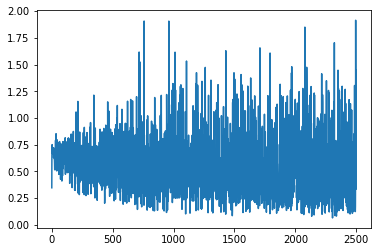

In [85]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [81]:
#get percision and recall, then eval. Do all prediction on test.
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


In [86]:
mSexism = 0
msright = 0
mswrong = 0
sCount = 0

mNeither = 0
mnright = 0
mnwrong = 0
nCount = 0

for i, elem in enumerate(X_test):
    label = y_test[i]
    test = lineToTensor(elem)
    
    if(label == 'sexism'):
        #print("sexisim")
        p = evaluate(test)
        p = p.unbind()
        pnum = p.index(max(p))
        predict = LTest[pnum]
        
        if predict == 'sexism':
            mSexism +=1
        else: mNeither +=1
        
        if (predict == label):
            msright +=1
        else: mswrong +=1
        sCount +=1
        
    else: #is neither
        #print("neither")
        p = evaluate(test)
        p = p.unbind()
        pnum = p.index(max(p))
        predict = LTest[pnum]
        
        if predict == 'sexism':
            mSexism +=1
        else: mNeither +=1
        
        if (predict == label):
            mnright +=1
        else: mnwrong +=1
        nCount +=1
        
print(mSexism,msright,mswrong,sCount,
mNeither, mnright, mnwrong, nCount)
        
'''
sPrecision = msright/ (msright + mswrong)
sRecall = msright/ sCount

nPrecision = mnright/ (mnright + mnwrong)
nRecall = mnright/ nCount

sf1 = 2*sPrecision*sRecall / (sPrecision+sRecall)
nf1 = 2*nPrecision*nRecall / (nPrecision+nRecall)

print("sexism precison %f", sPrecision)
print("sexism recall %f", sRecall)
print("sexism f1 %f", sf1)

print("neither precison %f", nPrecision)
print("neither recall %f", nRecall)
#print("neither f1 %f", nf1)

'''

1308 743 0 743 0 0 565 565


'\nsPrecision = msright/ (msright + mswrong)\nsRecall = msright/ sCount\n\nnPrecision = mnright/ (mnright + mnwrong)\nnRecall = mnright/ nCount\n\nsf1 = 2*sPrecision*sRecall / (sPrecision+sRecall)\nnf1 = 2*nPrecision*nRecall / (nPrecision+nRecall)\n\nprint("sexism precison %f", sPrecision)\nprint("sexism recall %f", sRecall)\nprint("sexism f1 %f", sf1)\n\nprint("neither precison %f", nPrecision)\nprint("neither recall %f", nRecall)\n#print("neither f1 %f", nf1)\n\n'

In [ ]:
#=========================================big ole tutorial below======================================================

In [26]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
#The majority of code is based on this tutorial as a primer into using PyTorch and it's RNN to preprocess, train,
#and evalutate data

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

#this is a preprocessing block of code. Grabs all names and keep names in caregroies. Converts all unicode to ascii,
#perserves the category, and stores it in category_lines. category_lines is a double array of categories to lines

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [16]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones'))

#demo showing first a conversion of a letter to a tensor, where the output dim is all ascii characters plus " .,;'"

#second is a deom showing one-hot encoding. Line to tensor generates a 3 dim representing line length, 1, and the
#letter length. Each Letter gets a 1-hot array and is chained together

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories) #rnn base created here

#here's an example of defining an RNN based off torch nn modules. This version is a base RNN class and not an LSTM

#After searching, it seems like RNN and LSTM are built into pytorch. We will most likely want to use LSTM based on
#our studies. Gonna try an example:

In [17]:
lstm = nn.LSTM(3, 3)
#nice. Ok, here's an LSTM example. Documentation is in modules.nn on pytorch, link:
#https://pytorch.org/docs/stable/nn.html , then search for LSTM

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

#example of prediction output

tensor([[-2.9143, -2.8531, -2.9223, -2.8982, -2.8782, -2.8364, -2.9175, -2.9579,
         -2.8601, -2.9149, -2.8950, -2.8652, -2.9368, -2.8223, -2.8346, -2.9574,
         -2.9368, -2.8419]], grad_fn=<LogSoftmaxBackward>)


In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

#category derived from output and index

('Portuguese', 13)


In [28]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(category_tensor)
    #print('category =', category, '/ line =', line)
    
#random training example fetcher

tensor([15])
tensor([11])
tensor([8])
tensor([7])
tensor([12])
tensor([0])
tensor([14])
tensor([8])
tensor([3])
tensor([16])


In [10]:
criterion = nn.NLLLoss()
#loss function setup

In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() #passovers, rnn was established beforehand

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

#train function

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess on print call
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses on plot request
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

#trains an RNN model!

5000 5% (0m 11s) 2.5485 Salazar / German ✗ (Portuguese)
10000 10% (0m 25s) 1.8149 Jong / Chinese ✗ (Korean)
15000 15% (0m 39s) 2.6806 Laycock / Czech ✗ (English)
20000 20% (0m 54s) 1.3831 Aswad / Arabic ✓
25000 25% (1m 7s) 2.9374 Powis / Greek ✗ (English)
30000 30% (1m 24s) 2.1906 Alphen / English ✗ (Dutch)
35000 35% (1m 36s) 1.2255 Naomhan / Irish ✓
40000 40% (1m 44s) 1.3728 Plisko / Russian ✗ (Czech)
45000 45% (1m 53s) 1.5808 Blazek / Polish ✗ (Czech)
50000 50% (2m 1s) 0.0284 Takishida / Japanese ✓
55000 55% (2m 9s) 2.9419 Han / Chinese ✗ (Korean)
60000 60% (2m 18s) 0.2369 Carboni / Italian ✓
65000 65% (2m 27s) 2.6289 Fertig / Scottish ✗ (German)
70000 70% (2m 36s) 1.9594 Abamelek / Czech ✗ (Russian)
75000 75% (2m 44s) 4.8320 Pitomets / Dutch ✗ (Russian)
80000 80% (2m 53s) 0.3765 Ciardha / Irish ✓
85000 85% (3m 1s) 0.7097 Veprentsev / Russian ✓
90000 90% (3m 9s) 0.1916 Ziemniak / Polish ✓
95000 95% (3m 18s) 1.6449 Rompu / Dutch ✓
100000 100% (3m 26s) 0.3486 Dam / Vietnamese ✓


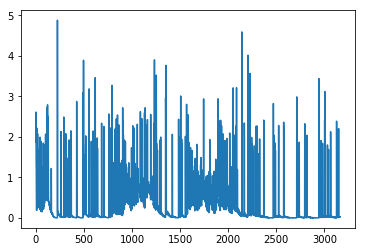

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

NameError: name 'n_categories' is not defined

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.82) Czech
(-1.11) Russian
(-1.70) Polish

> Jackson
(-0.15) Scottish
(-2.65) English
(-3.70) Russian

> Satoshi
(-0.77) Japanese
(-1.84) Polish
(-2.29) Scottish
